# Convolutional Neural Network - YOLO Basics
Autonomous driving - Car detection
- Object detection
- bounding boxes

## YOLO

YOLO ("you only look once") is a popular algoritm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

Drawing bounding boxes around every car you found in images folder. Here's an example of what your bounding boxes look like.

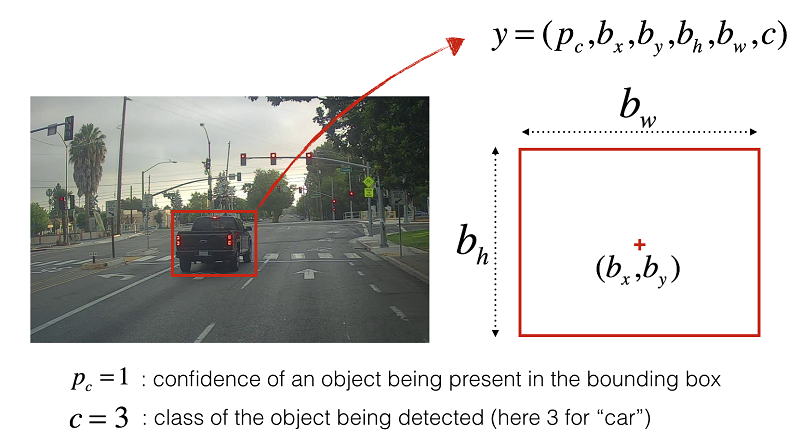

If you have 80 classes that you want YOLO to recognize, you can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1 and the rest of which are 0. The video lectures had used the latter representation; in this notebook, we will use both representations, depending on which is more convenient for a particular step.  

In this exercise, you will learn how YOLO works, then apply it to car detection. Because the YOLO model is very computationally expensive to train, we will load pre-trained weights for you to use. 

### Model details

First things to know:
- The **input** is a batch of images of shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

We will use 5 anchor boxes. So you can think of the YOLO architecture as the following: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).

Lets look in greater detail at what this encoding represents. 

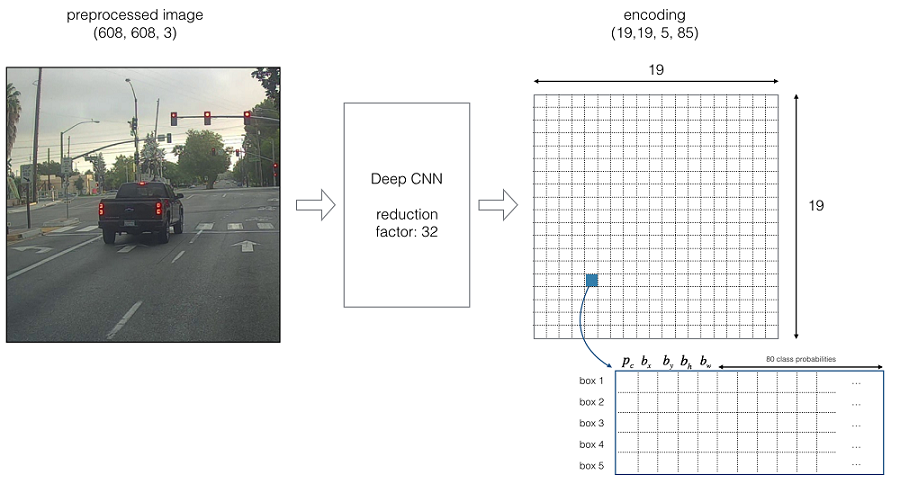

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

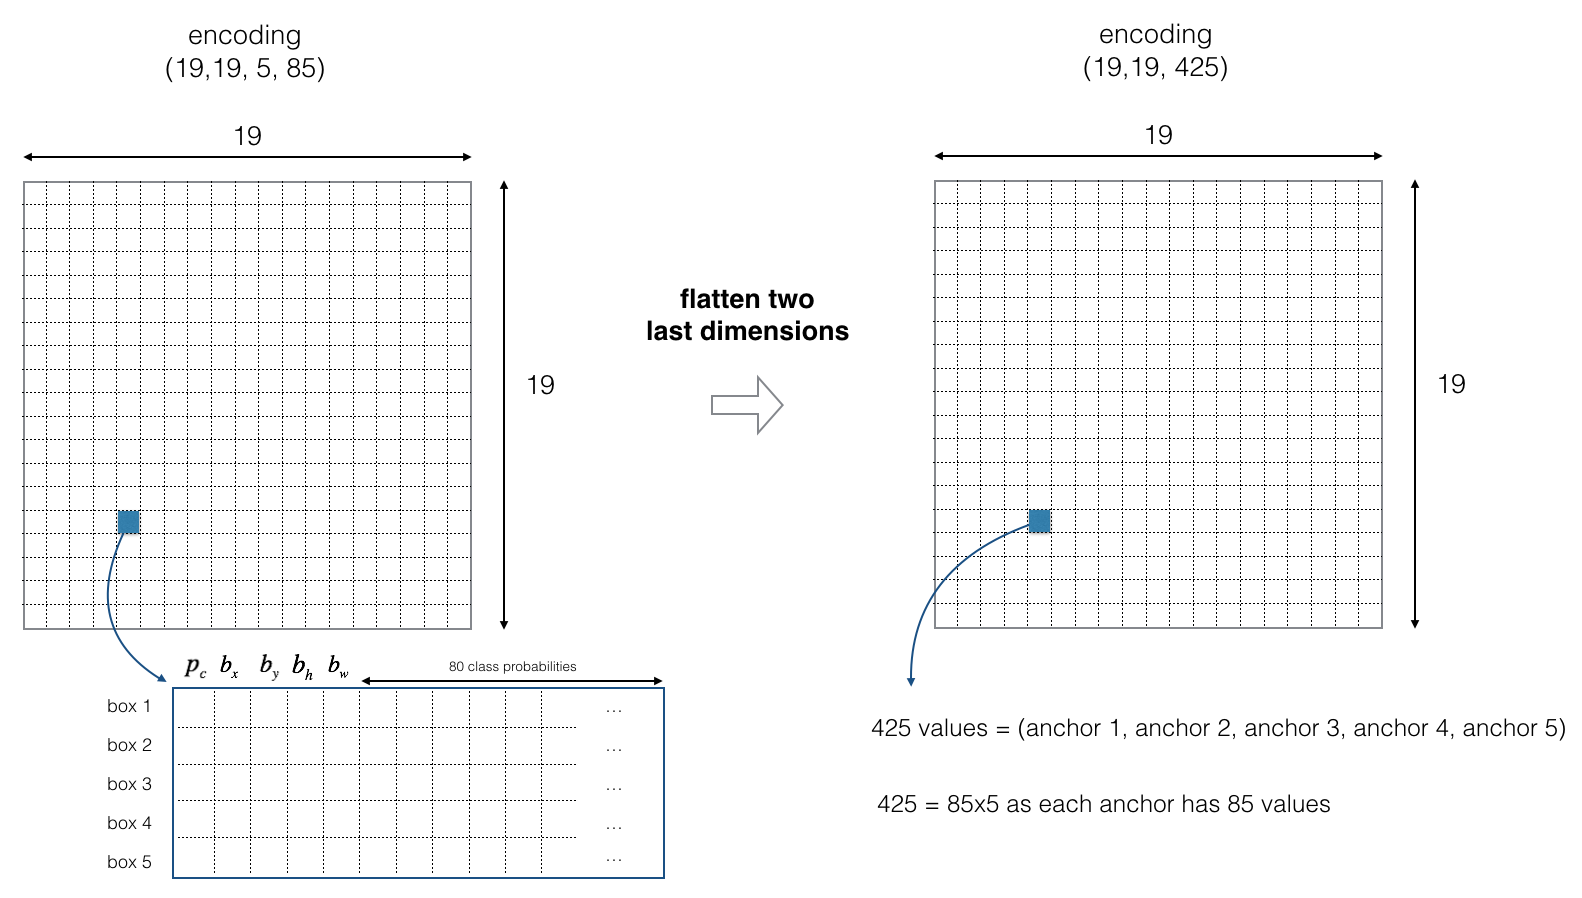

Now, for each box (of each cell) we will compute the following elementwise product and extract a probability that the box contains a certain class.

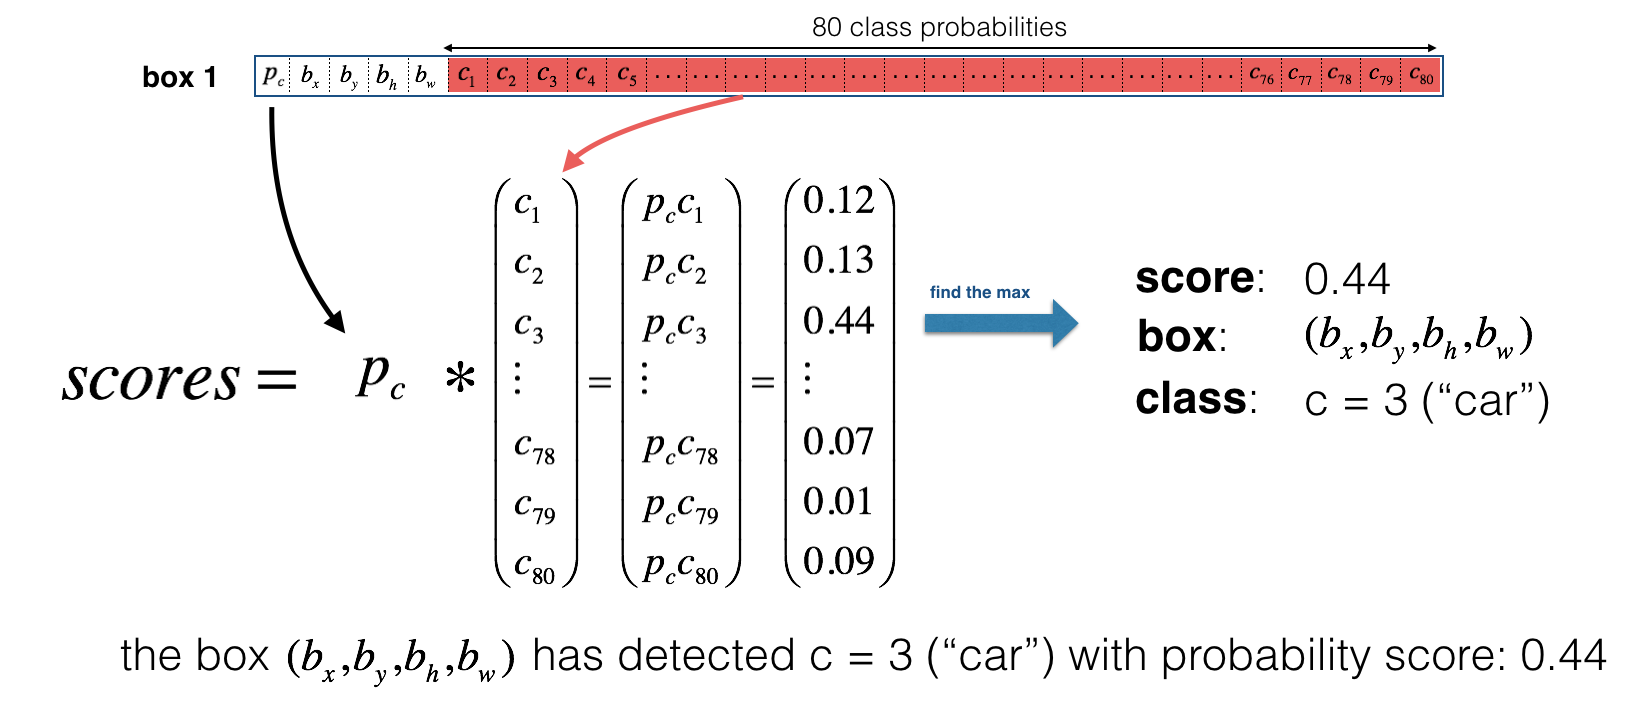

Here's one way to visualize what YOLO is predicting on an image:
- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across both the 5 anchor boxes and across different classes). 
- Color that grid cell according to what object that grid cell considers the most likely.

 Each of the 19x19 grid cells colored according to which class has the largest predicted probability in that cell.

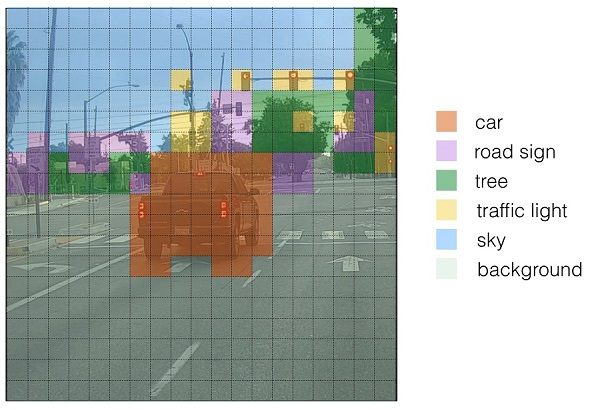

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 

Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  
Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes.

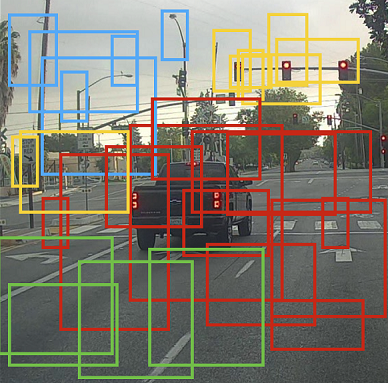

In the figure above, we plotted only boxes that the model had assigned a high probability to, but this is still too many boxes. You'd like to filter the algorithm's output down to a much smaller number of detected objects. To do so, you'll use non-max suppression. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class)
- Select only one box when several boxes overlap with each other and detect the same object.

#  Running YOLO pretrained model on images

**Summary for YOLO**:
- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and and 80 is the number of classes we'd like to detect
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output. 

In this part, you are going to use a pretrained model and test it on the car detection dataset. As usual, you start by **creating a session to start your graph**. Run the following cell.

In [6]:
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from keras.layers.merge import concatenate

import colorsys
import random

import PIL as pil
from PIL import ImageDraw,ImageFont
import imageio
import cv2

import os

Using TensorFlow backend.


In [7]:
sess = K.get_session()

## Defining Classes, Anchors and image shape.

In [8]:
def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

Recall that we are trying to detect 80 classes, and are using 5 anchor boxes. We have gathered the information about the 80 classes and 5 boxes in two files "coco_classes.txt" and "yolo_anchors.txt". Let's load these quantities into the model by running the next cell. 

The car detection dataset has 720x1280 images, which we've pre-processed into 608x608 images. 

In [9]:
class_names = read_classes("../Input/YoloDS/model_data/coco_classes.txt")
anchors = read_anchors("../Input/YoloDS/model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

## Loading a pretrained model

Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. You are going to load an existing pretrained Keras YOLO model stored in "yolo.h5". (These weights come from the official YOLO website, and were converted using a function written by Allan Zelener. References are at the end of this notebook. Technically, these are the parameters from the "YOLOv2" model, but we will more simply refer to it as "YOLO" in this notebook.) Run the cell below to load the model from this file.

In [10]:
yolo_model = load_model("../Input/YoloDS/model_data/yolo.h5")

Instructions for updating:
Colocations handled automatically by placer.


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


This loads the weights of a trained YOLO model. Here's a summary of the layers your model contains.

In [11]:
#yolo_model.summary()

**Note**: On some computers, you may see a warning message from Keras. Don't worry about it if you do--it is fine.

**Reminder**: this model converts a preprocessed batch of input images (shape: (m, 608, 608, 3)) into a tensor of shape (m, 19, 19, 5, 85) as explained in Figure (2).

##  Convert output of the model to usable bounding box tensors

The output of `yolo_model` is a (m, 19, 19, 5, 85) tensor that needs to pass through non-trivial processing and conversion. The following cell does that for you.   
`yolo_head()` Converts final layer features to bounding box parameters. 
    - input Parameters 
    - feats : tensor  Final convolutional layer features.
    - anchors : array-like    Anchor box widths and heights.
    - num_classes : int  Number of target classes.

In [12]:
def yolo_head(feats, anchors, num_classes):   
    num_anchors = len(anchors)

    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last

    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)

    conv_width_index = K.tile(K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])

    conv_index = K.cast(conv_index, dtype='float32')
    feats = K.reshape(feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.softmax(feats[..., 5:])

    # Adjust preditions to each spatial grid point and anchor size.
    # Note: YOLO iterates over height index before width index.

    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_confidence,box_xy, box_wh,  box_class_probs

In [13]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))


You added `yolo_outputs` to your graph. This set of 4 tensors is ready to be used as input by your `yolo_eval` function.

# Filtering boxes

`yolo_outputs` gave you all the predicted boxes of `yolo_model` in the correct format. You're now ready to perform filtering and select only the best boxes. Lets now call `yolo_eval`, which you had previously implemented, to do this. 

## Filtering with a threshold on class scores

You are going to apply a first filter by thresholding. You would like to get rid of any box for which the class "score" is less than a chosen threshold. 

The model gives you a total of 19x19x5x85 numbers, with each box described by 85 numbers. It'll be convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19 \times 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19 \times 19, 5, 4)$ containing $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes per cell.
- `box_class_probs`: tensor of shape $(19 \times 19, 5, 80)$ containing the detection probabilities $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.

**Exercise**: Implement `yolo_filter_boxes()`.
1. Compute box scores by doing the elementwise product as described in Figure 4. The following code may help you choose the right operator: 
```python
a = np.random.randn(19*19, 5, 1)
b = np.random.randn(19*19, 5, 80)
c = a * b # shape of c will be (19*19, 5, 80)
```
2. For each box, find:
    - the index of the class with the maximum box score ([Hint](https://keras.io/backend/#argmax)) (Be careful with what axis you choose; consider using axis=-1)
    - the corresponding box score ([Hint](https://keras.io/backend/#max)) (Be careful with what axis you choose; consider using axis=-1)
3. Create a mask by using a threshold. As a reminder: `([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4)` returns: `[False, True, False, False, True]`. The mask should be True for the boxes you want to keep. 
4. Use TensorFlow to apply the mask to box_class_scores, boxes and box_classes to filter out the boxes we don't want. You should be left with just the subset of boxes you want to keep. ([Hint](https://www.tensorflow.org/api_docs/python/tf/boolean_mask))

Reminder: to call a Keras function, you should use `K.function(...)`.

In [14]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    # Step 1: Compute box scores
    box_scores = box_confidence * box_class_probs
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes = K.argmax(box_scores, axis = -1)
    box_class_scores = K.max(box_scores, axis = -1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = (box_class_scores >= threshold)
    
    # Step 4: Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

## Non-max suppression ###

Even after filtering by thresholding over the classes scores, you still end up a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probabiliy) one of the 3 boxes

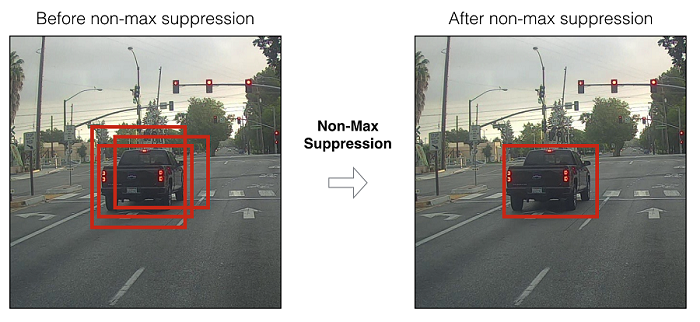

### IOU Implementation

Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.

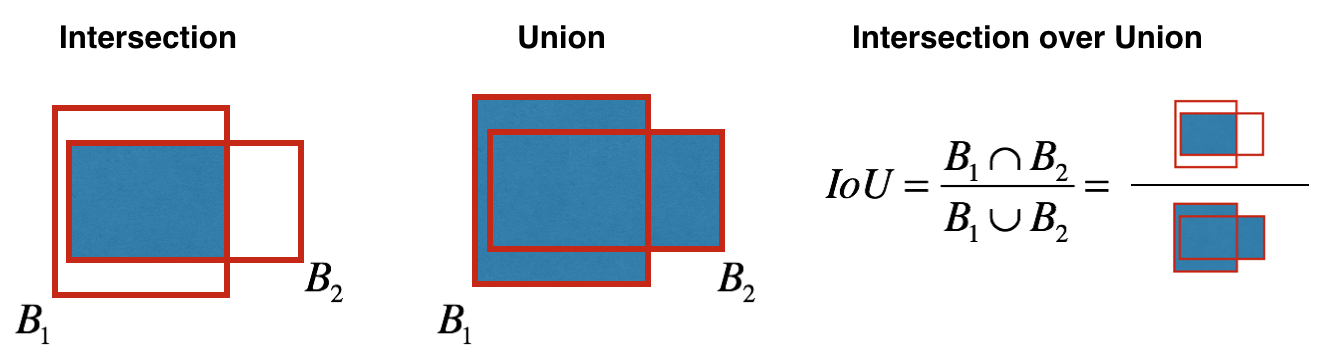

- we define a box using its two corners (upper left and lower right): (x1, y1, x2, y2) rather than the midpoint and height/width.
- To calculate the area of a rectangle you need to multiply its height (y2 - y1) by its width (x2 - x1)
- To find the coordinates (xi1, yi1, xi2, yi2) of the intersection of two boxes. 
    - xi1 = maximum of the x1 coordinates of the two boxes
    - yi1 = maximum of the y1 coordinates of the two boxes
    - xi2 = minimum of the x2 coordinates of the two boxes
    - yi2 = minimum of the y2 coordinates of the two boxes
    
This code uses the convention that (0,0) is the top-left corner of an image, (1,0) is the upper-right corner, and (1,1) the lower-right corner. 

In [15]:
def iou(box1, box2):
    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = np.maximum(box1[0], box2[0])
    yi1 = np.maximum(box1[1], box2[1])
    xi2 = np.minimum(box1[2], box2[2])
    yi2 = np.minimum(box1[3], box2[3])
    inter_area = np.abs((xi1 - xi2) * (yi1 - yi2))

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = np.abs((box1[2] - box1[0]) * (box1[3] - box1[1]))
    box2_area = np.abs((box2[2] - box2[0]) * (box2[3] - box2[1]))
    union_area = box1_area + box2_area - inter_area
   
    # compute the IoU
    iou = inter_area / union_area

    return iou

You are now ready to implement non-max suppression. The key steps are: 
1. Select the box that has the highest score.
2. Compute its overlap with all other boxes, and remove boxes that overlap it more than `iou_threshold`.
3. Go back to step 1 and iterate until there's no more boxes with a lower score than the current selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.


In [16]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5): 
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    nms_indices = tf.image.non_max_suppression( boxes, scores, max_boxes_tensor, iou_threshold, name=None)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

### Converts the yolo box coordinates 

converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2)

In [17]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

### Scales the predicted boxes in order to be drawable on the image

In [18]:
def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

## Wrapping up the filtering

It's time to implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions you've just implemented. 

**Exercise**: Implement `yolo_eval()` which takes the output of the YOLO encoding and filters the boxes using score threshold and NMS. There's just one last implementational detail you have to know. There're a few ways of representing boxes, such as via their corners or via their midpoint and height/width. YOLO converts between a few such formats at different times, using the following functions (which we have provided): 

```python
boxes = yolo_boxes_to_corners(box_xy, box_wh) 
```
which converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2) to fit the input of `yolo_filter_boxes`
```python
boxes = scale_boxes(boxes, image_shape)
```
YOLO's network was trained to run on 608x608 images. If you are testing this data on a different size image--for example, the car detection dataset had 720x1280 images--this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.  

Don't worry about these two functions; we'll show you where they need to be called.  

In [19]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10,score_threshold=.6, iou_threshold=.5):    
    # Retrieve outputs of the YOLO model
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold 
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
        
    return scores, boxes, classes

In [20]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)


## Run the graph on an image

Let the fun begin. You have created a (`sess`) graph that can be summarized as follows:

1. <font color='purple'> yolo_model.input </font> is given to `yolo_model`. The model is used to compute the output <font color='purple'> yolo_model.output </font>
2. <font color='purple'> yolo_model.output </font> is processed by `yolo_head`. It gives you <font color='purple'> yolo_outputs </font>
3. <font color='purple'> yolo_outputs </font> goes through a filtering function, `yolo_eval`. It outputs your predictions: <font color='purple'> scores, boxes, classes </font>

**Exercise**: Implement predict() which runs the graph to test YOLO on an image.
You will need to run a TensorFlow session, to have it compute `scores, boxes, classes`.

The code below also uses the following function:
```python
image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
```
which outputs:
- image: a python (PIL) representation of your image used for drawing boxes. You won't need to use it.
- image_data: a numpy-array representing the image. This will be the input to the CNN.

**Important note**: when a model uses BatchNorm (as is the case in YOLO), you will need to pass an additional placeholder in the feed_dict {K.learning_phase(): 0}.

## Preprocessing Image

In [21]:
def preprocess_image(img_path, model_image_size):
    #image_type = imghdr.what(img_path)
    image = pil.Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), pil.Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data

## Drawing Boxes to Output

In [22]:
def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

####################################################################################
def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, 
               colors,displayPredictionSummary=False):  
    
    fontSize=np.floor(3e-2 * image.size[1] + 0.5).astype('int32')
    font = pil.ImageFont.truetype(font='arial.ttf',size=fontSize)
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '       {} {:.2f}'.format(predicted_class, score)

        draw = pil.ImageDraw.Draw(image)
        label_size = draw.textsize(label,font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        if(displayPredictionSummary):
            print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

## Prediction

In [30]:
def CreateDirRecursive(file_path):
    directory = os.path.dirname(file_path)
    if(directory!=""):
        os.makedirs(directory, exist_ok=True)
    

In [27]:
def Predict(Sess, inputFileName,outputFileName="outputImage.jpg",
            displayPredictionSummary=False):
    
    # Preprocess your image
    image, image_data = preprocess_image(inputFileName, model_image_size = (608, 608))

    # Run the session with the correct tensors and placeholders in the feed_dict.
    out_scores,out_boxes, out_classes = sess.run([scores, boxes, classes], 
                                                  feed_dict = {yolo_model.input:image_data, 
                                                               K.learning_phase():0})
    
   
    # Print predictions info
    if(displayPredictionSummary):
        print('Found {} boxes for {}'.format(len(out_boxes), inputFileName))
    
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, 
               class_names, colors,displayPredictionSummary)
    
    # Save the predicted bounding box on the image
    
    CreateDirRecursive(outputFileName)
    image.save(outputFileName, quality=50)
    
    
    return outputFileName
    

In [44]:
def DisplayImage(imgFileName):
    img = pil.Image.open(imgFileName)
    plt.subplots(figsize=(200, 6))

    plt.imshow(img)

Found 7 boxes for ../Input/YoloDS/images/test1.jpg
       car 0.60 (925, 285) (1045, 374)
       car 0.66 (706, 279) (786, 350)
       bus 0.67 (5, 266) (220, 407)
       car 0.70 (947, 324) (1280, 705)
       car 0.74 (159, 303) (346, 440)
       car 0.80 (761, 282) (942, 412)
       car 0.89 (367, 300) (745, 648)


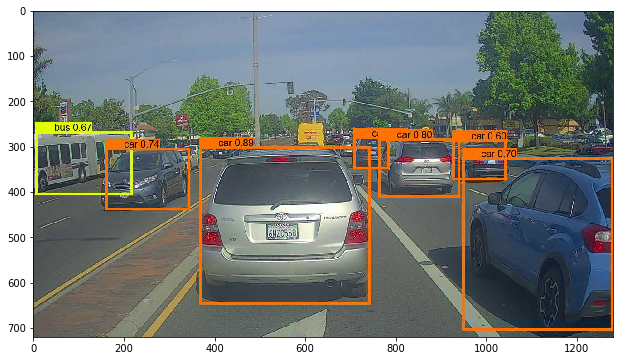

In [45]:
inputFileName="../Input/YoloDS/images/test1.jpg"
outputFileName=inputFileName.replace("Input","Output")
outputFileName=Predict(sess,inputFileName,outputFileName,True)
DisplayImage(outputFileName)

**What you should remember**:
- YOLO is a state-of-the-art object detection model that is fast and accurate
- It runs an input image through a CNN which outputs a 19x19x5x85 dimensional volume. 
- The encoding can be seen as a grid where each of the 19x19 cells contains information about 5 boxes.
- You filter through all the boxes using non-max suppression. Specifically: 
    - Score thresholding on the probability of detecting a class to keep only accurate (high probability) boxes
    - Intersection over Union (IoU) thresholding to eliminate overlapping boxes
- Because training a YOLO model from randomly initialized weights is non-trivial and requires a large dataset as well as lot of computation, we used previously trained model parameters in this exercise. If you wish, you can also try fine-tuning the YOLO model with your own dataset, though this would be a fairly non-trivial exercise. 